# Supernova Distance 2: Non-Linear Fit

In [58]:
from astroML.datasets import generate_mu_z
import matplotlib.pyplot as plt
import numpy as np

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process import kernels as k
from astropy.cosmology import LambdaCDM

from scipy.stats import norm as norm
import scipy

import dynesty
from dynesty import utils as dyfunc, plotting as dyplot


#Figures options!
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['font.size'] = 12

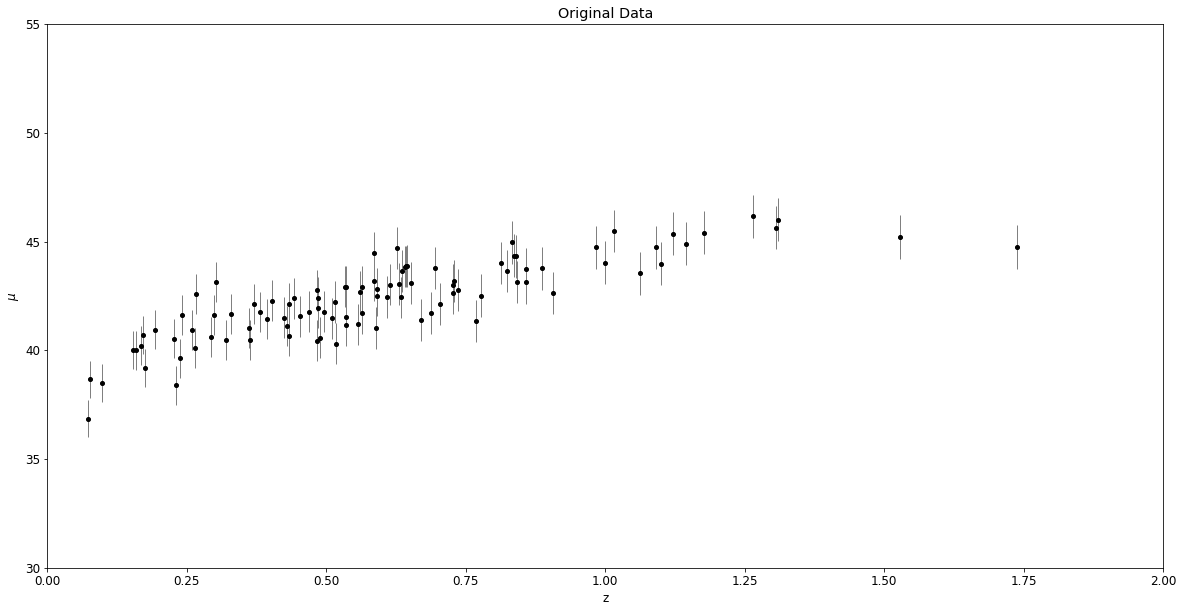

In [59]:
#Generating Samples
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='ko', markersize=4, ecolor='gray', lw=1)
plt.title('Original Data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0, 2)
plt.ylim(30, 55)
plt.show()

### Gaussian Process Regression

In [60]:
#Data Preprocessing
z_fit = z_sample[:, None]
zgrid = np.linspace(0.01, 2, 1000)

In [61]:
#Gaussian Process Regressor

#Kernel construction: Constant kernel scales the magnitude, while RBF is essentially a gaussian kernel
kernel = k.ConstantKernel(1.0) * k.RBF(4.)

gp = GaussianProcessRegressor(
                            kernel=kernel,
                            alpha=dmu           #alpha here is interpreted as additional gaussian noise on the measurement, dmu seems perfect to me!
                            )

#Training with full dataset
gp.fit(z_fit, mu_sample)

#Predicting on whole grid
fit, fit_err = gp.predict(zgrid[:, None], return_std=True)      #return_std also provides 1-sigma error on the fit

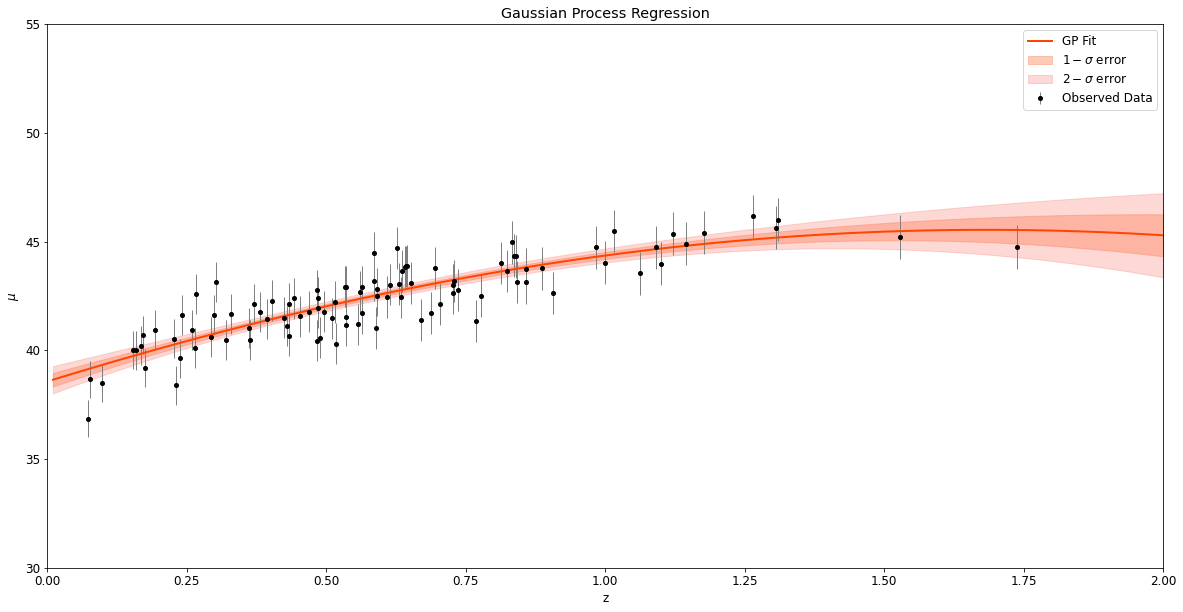

In [62]:
#Plotting Fit against observed data

#Observed
plt.errorbar(z_sample, mu_sample, dmu, fmt='ko', markersize=4, ecolor='gray', lw=1, label='Observed Data')

#Fit
plt.plot(zgrid, fit, c='orangered', lw=2, label='GP Fit')
plt.fill_between(zgrid, fit - fit_err, fit + fit_err, alpha=0.4, color='coral', label=r'$1-\sigma$ error')
plt.fill_between(zgrid, fit - 2*fit_err, fit + 2*fit_err, alpha=0.3, color='salmon', label=r'$2-\sigma$ error')

plt.title('Gaussian Process Regression')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0, 2)
plt.ylim(30, 55)
plt.legend()
plt.show()

### Cosmological Model

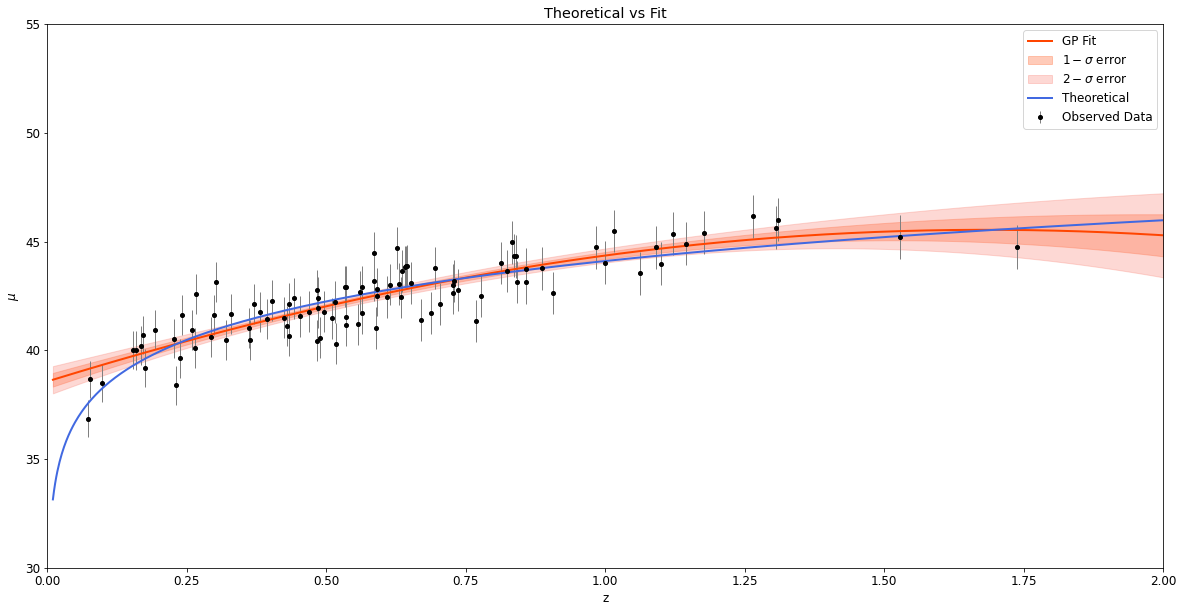

In [63]:
cosmological_model = LambdaCDM(H0=71, Om0=0.27, Ode0=1-0.27)

true_pdf_mu = cosmological_model.distmod(zgrid)

#Observed
plt.errorbar(z_sample, mu_sample, dmu, fmt='ko', markersize=4, ecolor='gray', lw=1, label='Observed Data')

#Fit
plt.plot(zgrid, fit, c='orangered', lw=2, label='GP Fit')
plt.fill_between(zgrid, fit - fit_err, fit + fit_err, alpha=0.4, color='coral', label=r'$1-\sigma$ error')
plt.fill_between(zgrid, fit - 2*fit_err, fit + 2*fit_err, alpha=0.3, color='salmon', label=r'$2-\sigma$ error')

#Theoretical
plt.plot(zgrid, true_pdf_mu, c='royalblue', lw=2, label='Theoretical')

plt.title('Theoretical vs Fit')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0, 2)
plt.ylim(30, 55)
plt.legend()
plt.show()

### Flat Universe with dark energy

$H_{0}$ and $ \Omega_{matter}$ are free parameters.

In [64]:
#The theoretical model is 
def flat_H0_omegam(redshift, h0, omegamatter=1):
    model = LambdaCDM(H0=h0, Om0=omegamatter, Ode0 = 1 - omegamatter)
    return model.distmod(redshift).value 

In [65]:
def dark_energy_loglike(theta):
    omega_matter, h0 = theta    
    if omega_matter < 0:
        return -np.inf
    else:
        mu_model = flat_H0_omegam(z_sample, h0, omega_matter)

    return np.sum(norm(loc=mu_model, scale=dmu).logpdf(mu_sample))

h0min = 30
h0max = 100
omega_matter_min = 0
omega_matter_max = 1

def dark_energy_priors(theta):

    #Since we are accessing indexes, copying input array
    prior = np.array(theta)

    #Setting Priors
    prior[0] = scipy.stats.uniform(loc=omega_matter_min, scale=omega_matter_max - omega_matter_min).ppf(theta[0])
    prior[1] = scipy.stats.uniform(loc=h0min, scale=h0max - h0min).ppf(theta[1])

    return prior

In [66]:
#Sampling
ndim = 2
sampler = dynesty.NestedSampler(dark_energy_loglike, dark_energy_priors, ndim, nlive=1000)

sampler.run_nested()
print('Sampling Done')

2780it [00:36, 75.59it/s, +1000 | bound: 0 | nc: 1 | ncall: 16663 | eff(%): 22.685 | loglstar:   -inf < -132.814 <    inf | logz: -135.320 +/-  0.034 | dlogz:  0.001 >  1.009]

Sampling Done


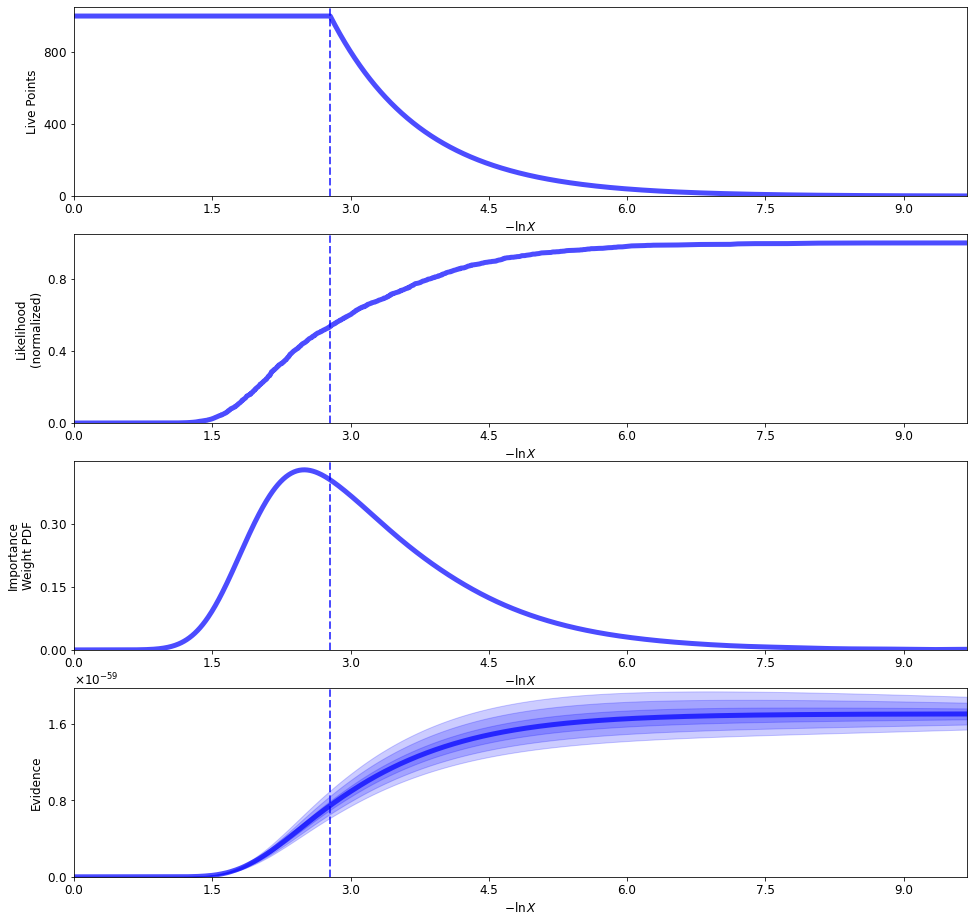

In [67]:
result = sampler.results

#Summary plots
s_fig, s_axes = dyplot.runplot(result)

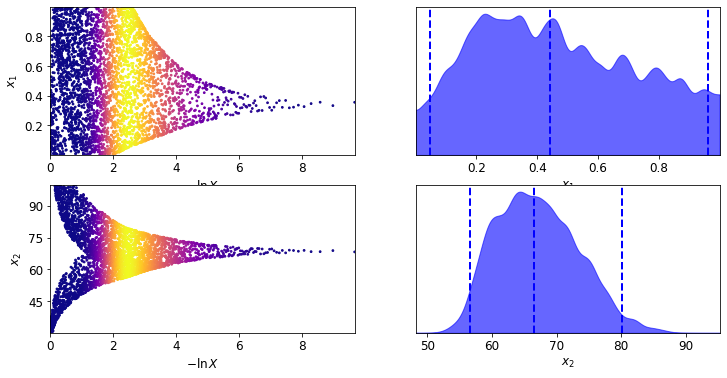

In [68]:
#Trace plots
t_fig, t_axes = dyplot.traceplot(result)

In [69]:
#Gathering Samples and weights
samples = result.samples  # samples
weights = np.exp(result.logwt - result.logz[-1])  # normalized weights

#Finding the 68% quantiles
quantiles = [dyfunc.quantile(sample_i, [0.16, 0.84], weights=weights) for sample_i in samples.T]
print('68% credible regions for Omega Matter, H0 are:\n ' + str(quantiles) + '\n')

#Mean and covariance matrix
mean, cov = dyfunc.mean_and_cov(samples, weights)
print('Mean and covariance for Omega Matter, H0 are: ' + str(mean) + '\n' + str(cov))

#Renormalizing
de_samples_equal = dyfunc.resample_equal(samples, weights)

#Gathering Evidence
de_evidence = result.logz[-1]
print('Evidence for Dark Energy is: ', de_evidence)

68% credible regions for Omega Matter, H0 are:
 [[0.1916124337229322, 0.7802448484122181], [60.3055837940421, 73.80645911299683]]

Mean and covariance for Omega Matter, H0 are: [ 0.4689914  67.01890135]
[[ 0.06724166 -1.41547191]
 [-1.41547191 39.59310627]]
Evidence for Dark Energy is:  -135.31954624981367


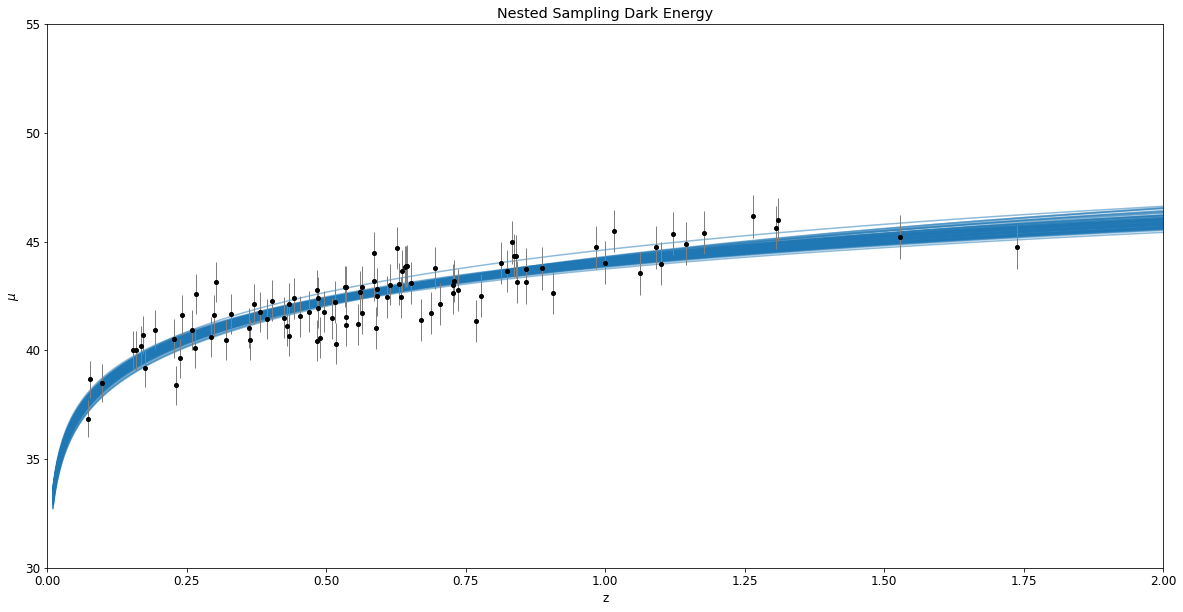

In [70]:
#Visualizing the first 50 samples
for omegamatter, h0 in de_samples_equal[::50]:
    plt.plot(zgrid, flat_H0_omegam(zgrid, h0=h0, omegamatter=omegamatter), c='C0', alpha=0.5)

plt.errorbar(z_sample, mu_sample, dmu, fmt='ko', markersize=4, ecolor='gray', lw=1)
plt.title('Nested Sampling Dark Energy')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0, 2)
plt.ylim(30, 55)
plt.show()

### Flat Universe with matter only

$H_{0}$ is a free parameter and $\Omega_{matter} = 1$ is fixed.

In [71]:
def h0_loglike(theta):
    h0 = float(theta)
    omega_matter = 1

    mu_model = flat_H0_omegam(z_sample, h0, omega_matter)

    return np.sum(norm(loc=mu_model, scale=dmu).logpdf(mu_sample))

h0min = 30
h0max = 100

def h0_prior(theta):

    #Since we are accessing indexes, copying input array
    prior = np.array(theta)

    #Setting Priors
    prior[0] = scipy.stats.uniform(loc=h0min, scale=h0max - h0min).ppf(theta[0])

    return prior

In [72]:
#Sampling
ndim = 1
sampler = dynesty.NestedSampler(h0_loglike, h0_prior, ndim, nlive=1000)

sampler.run_nested()
print('Sampling Done')

2767it [00:25, 108.26it/s, +1000 | bound: 0 | nc: 1 | ncall: 15893 | eff(%): 23.702 | loglstar:   -inf < -133.530 <    inf | logz: -135.918 +/-    nan | dlogz:  0.001 >  1.009]

Sampling Done


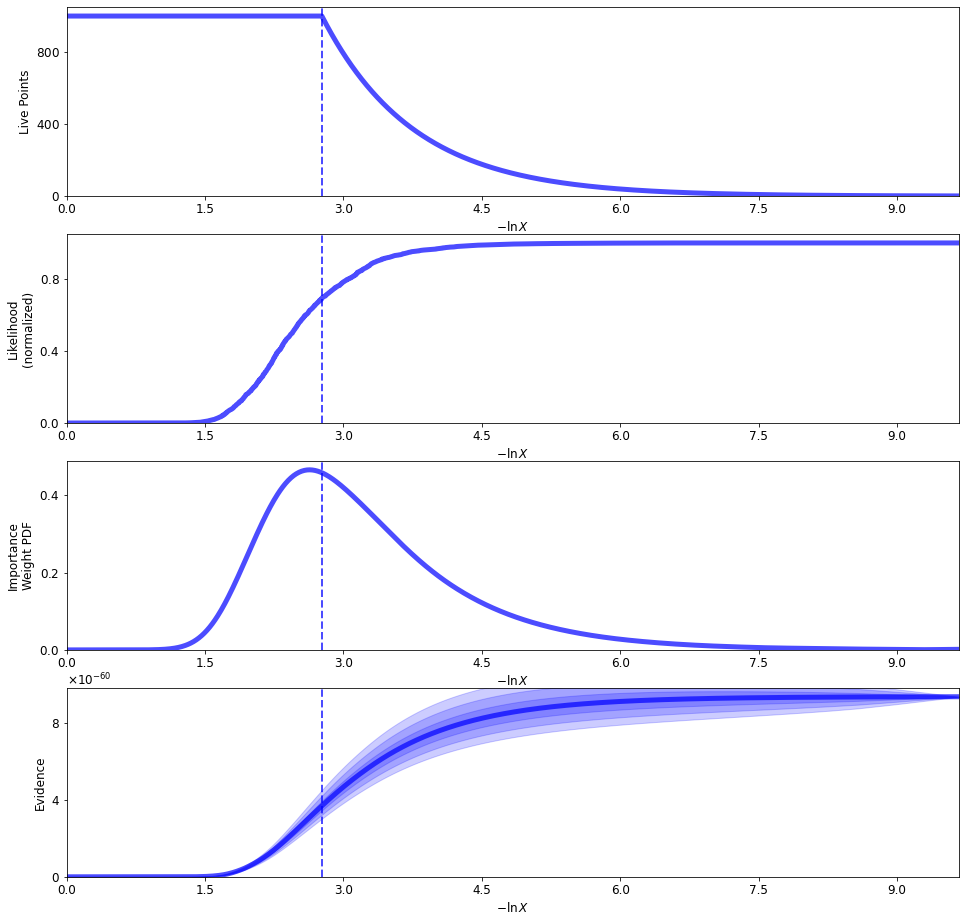

In [73]:
result = sampler.results

#Summary plots
s_fig, s_axes = dyplot.runplot(result)

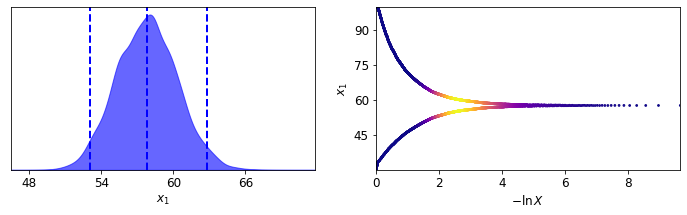

In [74]:
#Trace plots
t_fig, t_axes = dyplot.traceplot(result)

In [75]:
#Gathering Samples and weights
samples = result.samples  # samples
weights = np.exp(result.logwt - result.logz[-1])  # normalized weights

#Finding the 68% quantiles
quantiles = [dyfunc.quantile(sample_i, [0.16, 0.84], weights=weights) for sample_i in samples.T]
print('68% credible region for H0 is:\n ' + str(quantiles) + '\n')

#Mean and covariance matrix
mean, cov = dyfunc.mean_and_cov(samples, weights)
print('Mean and variance for H0 are: ' + str(mean) + '\n' + str(cov))

#Renormalizing
matter_samples_equal = dyfunc.resample_equal(samples, weights)

#Gathering Evidence
matter_evidence = result.logz[-1]
print('\nEvidence for Matter only is: ', matter_evidence)

68% credible region for H0 is:
 [[55.265910555526105, 60.2284786105991]]

Mean and variance for H0 are: [57.775158]
[[6.28484062]]

Evidence for Matter only is:  -135.91750020681857


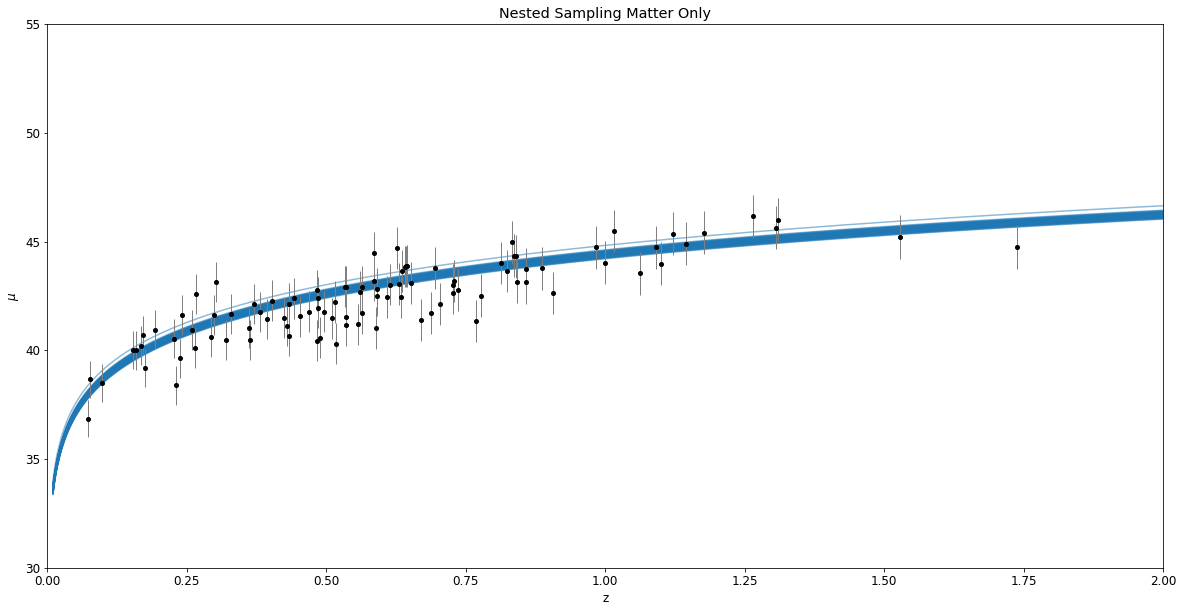

In [76]:
#Visualizing the first 50 samples
for h0 in matter_samples_equal[::50]:
    plt.plot(zgrid, flat_H0_omegam(zgrid, h0=float(h0), omegamatter=omegamatter), c='C0', alpha=0.5)

plt.errorbar(z_sample, mu_sample, dmu, fmt='ko', markersize=4, ecolor='gray', lw=1)
plt.title('Nested Sampling Matter Only')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0, 2)
plt.ylim(30, 55)
plt.show()

In [77]:
print('Evidence for Dark Energy is: ', de_evidence)
print('\nEvidence for Matter only is: ', matter_evidence)
print('\nBayes Factor is: ', de_evidence/matter_evidence)

Evidence for Dark Energy is:  -135.31954624981367

Evidence for Matter only is:  -135.91750020681857

Bayes Factor is:  0.9956006109875841


### Comparing the samples gathered with the nested sampling (matter only) with the samples from the gaussian process regression

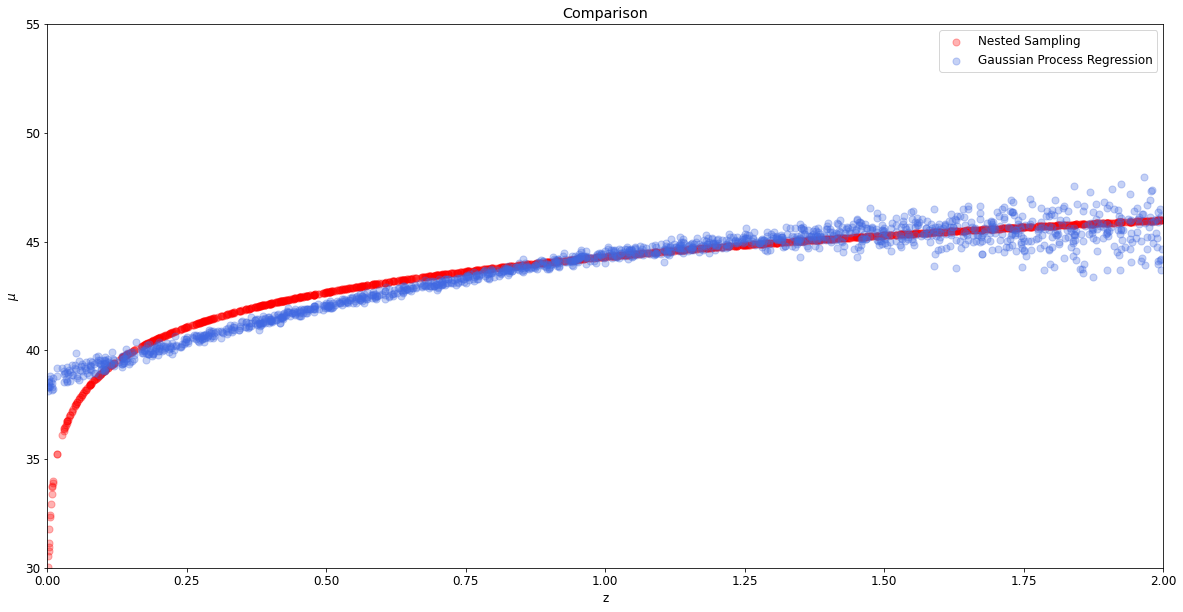

In [79]:
random_z = np.random.uniform(0, 2, 1500)

nested = []
gpr = []

for z in random_z:
    #Nested Sampling
    h0 = np.random.choice(matter_samples_equal[0])
    nested.append(flat_H0_omegam(z, h0))

    #Gaussian Process Regression
    mu, sigma = gp.predict([[z]], return_std=True)
    gpr.append(np.random.normal(loc=mu, scale=sigma)) #Appending a random draw from a gaussian!

#Plotting
plt.scatter(random_z, nested, s=50, c='red', alpha=0.3, label='Nested Sampling')
plt.scatter(random_z, gpr, s=50, c='royalblue', alpha=0.3, label='Gaussian Process Regression')

plt.title('Comparison')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0, 2)
plt.ylim(30, 55)
plt.legend()
plt.show()

### Putting it all together!

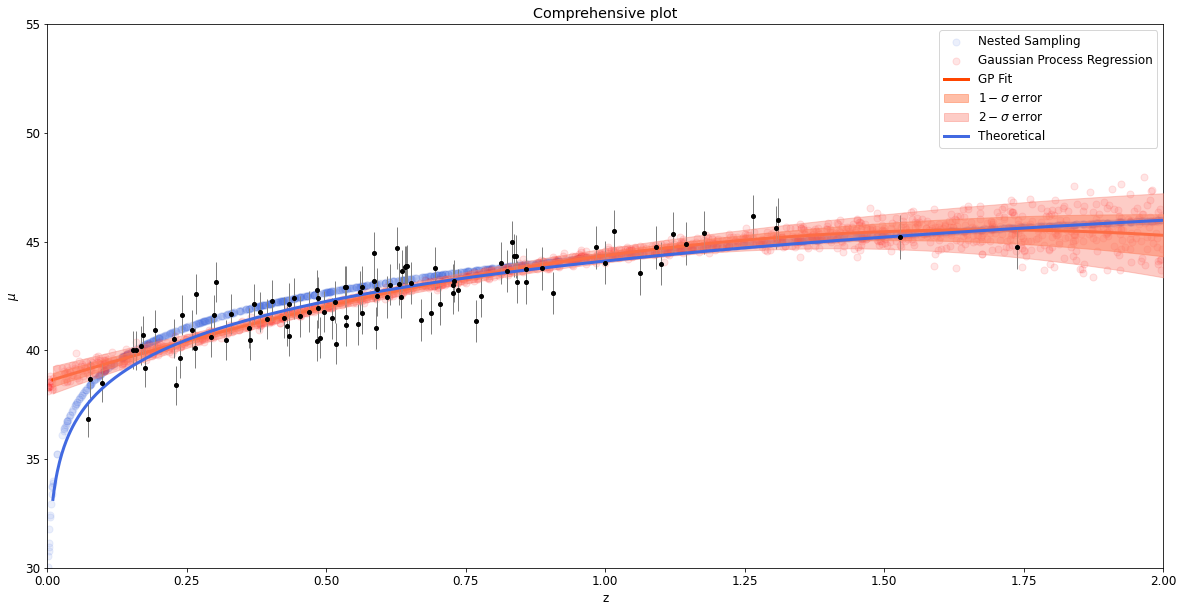

In [90]:
#Nested
plt.scatter(random_z, nested, s=50, c='royalblue', alpha=0.1, label='Nested Sampling', zorder=0)

#GPR
plt.scatter(random_z, gpr, s=50, c='red', alpha=0.1, label='Gaussian Process Regression', zorder=0)

#Observed
plt.errorbar(z_sample, mu_sample, dmu, fmt='ko', markersize=4, ecolor='gray', lw=1, zorder=3)

#GPR Fit
plt.plot(zgrid, fit, c='orangered', lw=3, label='GP Fit', zorder=2)
plt.fill_between(zgrid, fit - fit_err, fit + fit_err, alpha=0.5, color='coral', label=r'$1-\sigma$ error', zorder=3)
plt.fill_between(zgrid, fit - 2*fit_err, fit + 2*fit_err, alpha=0.4, color='salmon', label=r'$2-\sigma$ error', zorder=3)

#Theoretical
plt.plot(zgrid, true_pdf_mu, c='royalblue', lw=3, label='Theoretical', zorder=3)

plt.title('Comprehensive plot')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0, 2)
plt.ylim(30, 55)
plt.legend()
plt.show()